In [90]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics

In [91]:
data = pd.read_csv('./gun_violence_dataset/incidents_dataset.csv', index_col=0, parse_dates=['date'], infer_datetime_format=True)

# Delete rows with an average age above 100
data.drop(data[data.average_age >= 100].index, inplace=True)

data.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,congressional_district,latitude,longitude,...,concealed carry license,assault weapon,lockdown/alert,tsa action,terrorism,ghost gun,political violence,mistaken id,nav,gun buy back action
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,14.0,40.3467,-79.8559,...,False,False,False,False,False,False,False,False,False,False
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,43.0,33.9090,-118.3330,...,False,False,False,False,False,False,False,False,False,False
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,9.0,41.4455,-82.1377,...,False,False,False,False,False,False,False,False,False,False
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,6.0,39.6518,-104.8020,...,False,False,False,False,False,False,False,False,False,False
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,6.0,36.1140,-79.9569,...,False,False,False,False,False,False,False,False,False,False


In [92]:
# Columns selection and preprocessing

data.dropna(subset=data.columns[18:], inplace=True)

# We assume that there are no guns involved when the exact value is unknown 
data.n_guns_involved.fillna(0, inplace=True)
data.minors_involved.fillna(False, inplace=True)
data.n_killed.fillna(data.n_killed.median(), inplace=True)
data.n_victims.fillna(data.n_victims.median(), inplace=True)
data.n_suspects.fillna(data.n_suspects.median(), inplace=True)
data.average_age.fillna(data.average_age.median(), inplace=True)
data.women_percentage.fillna(data.women_percentage.median(), inplace=True)

data_selection = data.drop(columns=['notes', 'congressional_district', 'incident_id', 'date', 'address', 'city_or_county'])

data_preproc = pd.concat(
    [
        data_selection.drop(columns=['state', 'stolen_gun_involved']), 
        pd.get_dummies(data_selection.state, prefix='state'),
        pd.get_dummies(data_selection.stolen_gun_involved, prefix='stolen_gun_involved')
    ], 
    axis=1
)

In [93]:
state_encoder = LabelEncoder() 

state_labels = state_encoder.fit_transform(data.state)

len(np.unique(state_labels))

51

# Clustering K-Means

In [94]:
kmeans = KMeans(n_clusters=len(np.unique(state_labels)))

kmeans_clusters = kmeans.fit_predict(data_preproc)

In [95]:
# We apply a dimensionality reduction algorithm (Principal Component Analysis). This is just used for visualization purposes
pca = PCA(3)

pca_res = pca.fit_transform(data_preproc)

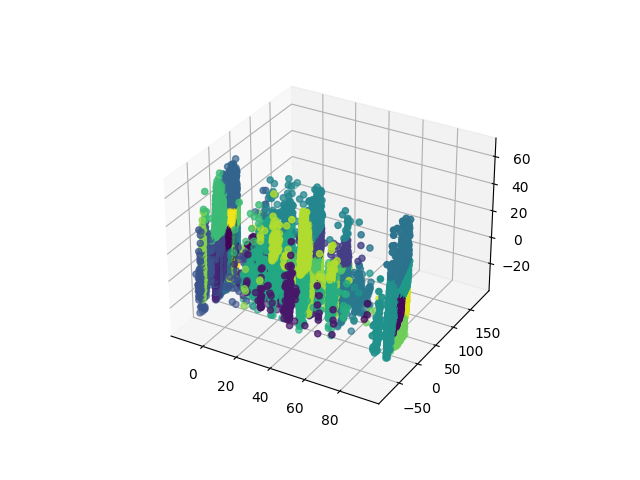

In [96]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=pca_res[:,0], ys=pca_res[:,1], zs=pca_res[:, 2], c=kmeans_clusters)

In [97]:
# We study the similarity between a divition of the data by state and the automatic clustering given by KMeans when the number of clusters
# corresponds to the number of states in the dataset

print('We calculate some metrics to test if the states correlate with the clusters:')
print('- Rand_score: ', metrics.rand_score(state_labels, kmeans_clusters))
print('- Adjusted_rand_score: ', metrics.adjusted_rand_score(state_labels, kmeans_clusters))
print('- Adjusted_mutual_info_score: ', metrics.adjusted_mutual_info_score(state_labels, kmeans_clusters))
print('- Hormalized_mutual_info_score: ', metrics.normalized_mutual_info_score(state_labels, kmeans_clusters))
print('- Homogeneity_score: ', metrics.homogeneity_score(state_labels, kmeans_clusters))
print('- Completeness_score: ', metrics.completeness_score(state_labels, kmeans_clusters))
print('- Fowlkes_mallows_score: ', metrics.fowlkes_mallows_score(state_labels, kmeans_clusters))

# As we see there is some correlation, but not much

We calculate some metrics to test if the states correlate with the clusters:
- Rand_score:  0.9504971732675996
- Adjusted_rand_score:  0.29416444948172266
- Adjusted_mutual_info_score:  0.5098428341296367
- Hormalized_mutual_info_score:  0.5105979691237662
- Homogeneity_score:  0.5065198153292166
- Completeness_score:  0.5147423249857206
- Fowlkes_mallows_score:  0.3199391414008518


In [98]:
# We calculate a few metrics to study the clusters by themselves

print('We calculate some metrics to test whether the clusters are good:')

# The higher the calinski_harabasz_score value is, the better. This measures separation between clusters and cohesion within the cluster
print('- Calinski_harabasz_score: ', metrics.calinski_harabasz_score(data_preproc, kmeans_clusters))
# The lower the davies_bouldin_score value is, the better.
print('- Davies_bouldin_score: ', metrics.davies_bouldin_score(data_preproc, kmeans_clusters))

We calculate some metrics to test whether the clusters are good:
- Calinski_harabasz_score:  97452.59837351198
- Davies_bouldin_score:  1.0843977864387937


In [99]:
# We study two metrics over a range of values in order to see how many clusters are needed to get an optimal division
cluster_metrics = []

for i in range(2, 51):
    print('Iter ', i)
    kmeans = KMeans(n_clusters=i)
    kmeans_clusters = kmeans.fit_predict(data_preproc)
    cluster_metrics.append((
        metrics.davies_bouldin_score(data_preproc, kmeans_clusters), 
        metrics.calinski_harabasz_score(data_preproc, kmeans_clusters)
    ))

cluster_metrics = np.array(cluster_metrics)

Iter  2
Iter  3
Iter  4
Iter  5
Iter  6
Iter  7
Iter  8
Iter  9
Iter  10
Iter  11
Iter  12
Iter  13
Iter  14
Iter  15
Iter  16
Iter  17
Iter  18
Iter  19
Iter  20
Iter  21
Iter  22
Iter  23
Iter  24
Iter  25
Iter  26
Iter  27
Iter  28
Iter  29
Iter  30
Iter  31
Iter  32
Iter  33
Iter  34
Iter  35
Iter  36
Iter  37
Iter  38
Iter  39
Iter  40
Iter  41
Iter  42
Iter  43
Iter  44
Iter  45
Iter  46
Iter  47
Iter  48
Iter  49
Iter  50


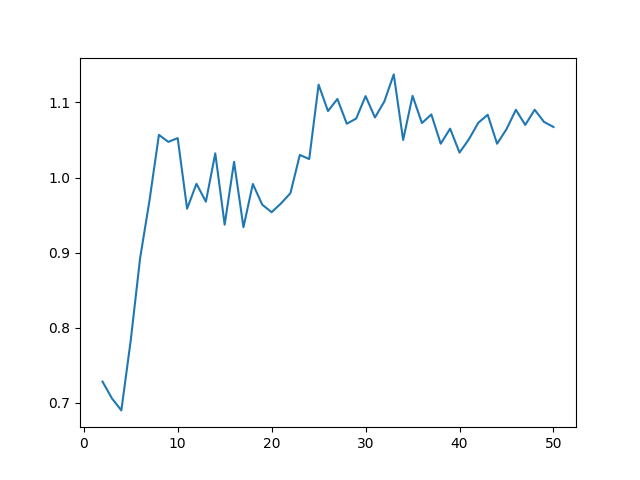

In [100]:
# Here we compare 49 clusterings using the Davies Bouldin Score
fig = plt.figure('Davies Bouldin Score over different number of clusters')
ax = fig.add_subplot()
ax.plot(np.arange(2, 51), cluster_metrics[:, 0])
# The best number of clusters seems to be 4, but not by much

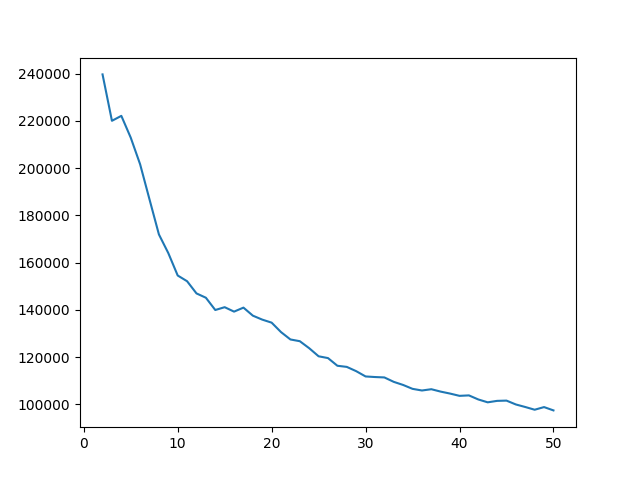

In [101]:
# Here we compare 49 clusterings using the Calinski Harabasz Score
fig = plt.figure('Calinski Harabasz Score over different number of clusters')
ax = fig.add_subplot()
ax.plot(np.arange(2, 51), cluster_metrics[:, 1])
# It does not seem like any number of clusters is any good

In [102]:
# As we see in the previous plots, it is hard to apply a good clustering for this dataset. However, different algorithms might work. 

# Clustering DBSCAN

In [103]:
#  Euclidean distance with kd_tree
dbscan = DBSCAN(eps=10, metric='euclidean', algorithm='kd_tree')

# Downsampling is necesary in order to get a response in a reasonable time
data_preproc_downsampled = data_preproc.sample(frac=0.2)

dbscan_clusters = dbscan.fit_predict(data_preproc_downsampled)

# We calculate the number of outliers because unlike KMeans, this is a density-based algorithm which returns apparent outliers
# -1s are the elements that do not belong to any cluster
print("Outliers:", np.sum(dbscan_clusters == -1) / len(dbscan_clusters))

Outliers: 0.0032407207362917514


In [104]:
pca = PCA(3)

not_outliers = dbscan_clusters[dbscan_clusters != -1]

pca_res = pca.fit_transform(data_preproc_downsampled[dbscan_clusters != -1])

np.unique(not_outliers)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

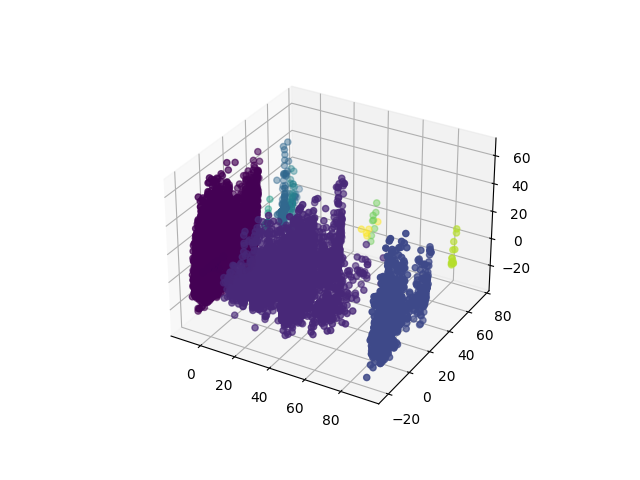

In [105]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=pca_res[:,0], ys=pca_res[:,1], zs=pca_res[:, 2], c=not_outliers)

In [106]:
# We calculate a few metrics to study the clusters by themselves

print('We calculate some metrics to test whether the clusters are good:')

print('- Calinski_harabasz_score: ', metrics.calinski_harabasz_score(data_preproc_downsampled, dbscan_clusters))
print('- Davies_bouldin_score: ', metrics.davies_bouldin_score(data_preproc_downsampled, dbscan_clusters))

# As we can see comparing these with previous values given by KMeans, this clustering is not very good either

We calculate some metrics to test whether the clusters are good:
- Calinski_harabasz_score:  7569.845780763429
- Davies_bouldin_score:  1.4526035103935255


In [107]:
#  Manhattan distance with kd_tree
dbscan = DBSCAN(eps=10, metric='manhattan', algorithm='kd_tree')

dbscan_clusters = dbscan.fit_predict(data_preproc_downsampled)

print("Outliers:", np.sum(dbscan_clusters == -1) / len(dbscan_clusters))

Outliers: 0.05777124832562762


In [108]:
# We calculate a few metrics to study the clusters by themselves
print('We calculate some metrics to test whether the clusters are good:')

print('- Calinski_harabasz_score: ', metrics.calinski_harabasz_score(data_preproc_downsampled, dbscan_clusters))
print('- Davies_bouldin_score: ', metrics.davies_bouldin_score(data_preproc_downsampled, dbscan_clusters))

# As we can see comparing these with previous values, this clustering is worse than the previous one

We calculate some metrics to test whether the clusters are good:
- Calinski_harabasz_score:  1868.73985187941
- Davies_bouldin_score:  1.6138113456038372


In [109]:
#  Euclidean distance with ball_tree
dbscan = DBSCAN(eps=10, metric='euclidean', algorithm='ball_tree')

dbscan_clusters = dbscan.fit_predict(data_preproc_downsampled)

print("Outliers:", np.sum(dbscan_clusters == -1) / len(dbscan_clusters))

Outliers: 0.0032407207362917514


In [110]:
# We calculate a few metrics to study the clusters by themselves
print('We calculate some metrics to test whether the clusters are good:')

print('- Calinski_harabasz_score: ', metrics.calinski_harabasz_score(data_preproc_downsampled, dbscan_clusters))
print('- Davies_bouldin_score: ', metrics.davies_bouldin_score(data_preproc_downsampled, dbscan_clusters))

# As we can see comparing these with its kd_tree equivalent values for Euclidean distance, this clustering is a little bit better

We calculate some metrics to test whether the clusters are good:
- Calinski_harabasz_score:  7569.845780763429
- Davies_bouldin_score:  1.4526035103935255


In [111]:
#  Euclidean distance with ball_tree
dbscan = DBSCAN(eps=10, metric='manhattan', algorithm='ball_tree')

dbscan_clusters = dbscan.fit_predict(data_preproc_downsampled)

print("Outliers:", np.sum(dbscan_clusters == -1) / len(dbscan_clusters))

Outliers: 0.05777124832562762


In [112]:
# We calculate a few metrics to study the clusters by themselves
print('We calculate some metrics to test whether the clusters are good:')

print('- Calinski_harabasz_score: ', metrics.calinski_harabasz_score(data_preproc_downsampled, dbscan_clusters))
print('- Davies_bouldin_score: ', metrics.davies_bouldin_score(data_preproc_downsampled, dbscan_clusters))

# As we can see comparing these with its kd_tree equivalent values for Euclidean distance, this clustering is a little bit better

We calculate some metrics to test whether the clusters are good:
- Calinski_harabasz_score:  1868.73985187941
- Davies_bouldin_score:  1.6138113456038372


# Conclusions

1. This dataset does not seem appropiate for a good clustering result. This does not mean that a clustering is not possible, but the result might not be useful or easily undestood given their parameters.

2. KMeans might give a reasonable result for 4 clusters, but not all metrics agree with this. This is implied by the Davies Bouldin Score plot.

3. DBSCAN, while a good algorithm which returns reasonable results when visualized using a PCA, gives worse results than KMeans using the tested parameters. Also, the performance is orders of magnitude worse.

4. For DBSCAN, we use Manhattan distance with two approximations, kd_tree and ball_tree, and we got the same results. This means the metric is less sensitive to changes in the algorithm, probably due to the high dimensionality of the data. Moreover, we use Euclidean distance and we got better results.